# Small DAE Simulations

In [1]:
from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt

## Example 1

Simulate the following ODE in the domain $t\in[0,2]$:

$$ \frac{dz}{dt} = z^2 - 2z + 1 $$

with the initial condition, $z(0)=-3$. Use any collocation method. Compare the result with the analytical solution:

$$ z(t) = \frac{4t-3}{4t+1}$$

and also with SciPy's RK45 solver.

Please recompile / update your pynumero_ASL library.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       87
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       13

Total number of variables............................:       26
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables w

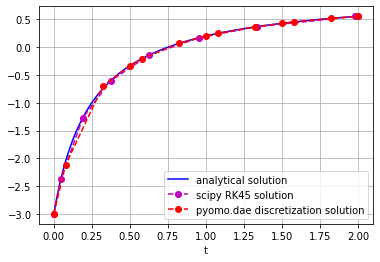

In [2]:
model = m = ConcreteModel()

m.t = ContinuousSet(bounds=(0,2))

m.z = Var(m.t)
m.dzdt = DerivativeVar(m.z)

m.obj = Objective(expr=1) # Dummy Objective

def _zdot(m, i):
    return m.dzdt[i] == m.z[i]**2 - 2*m.z[i] + 1
m.zdot = Constraint(m.t,rule=_zdot)

def _init_con(m):
    return m.z[0] == -3
m.init_con = Constraint(rule=_init_con)

# Discretize using backward finite difference
#discretizer = TransformationFactory('dae.finite_difference')
#discretizer.apply_to(m, nfe=50, scheme='BACKWARD')

# Discretize using collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=4, ncp=3 , scheme='LAGRANGE-RADAU')

# Solve using Pyomo IPOPT
solver = SolverFactory('cyipopt')
solver.solve(m, tee=True)

analytical_t = [0.01*i for i in range(0,201)]
analytical_z = [(4*t-3)/(4*t+1) for t in analytical_t]

colloc_t = list(m.t)
colloc_z = [value(m.z[i]) for i in m.t]

# Solve using Scipy RK45

def dzdt(t, z):
    return z**2 - 2*z + 1

sol = solve_ivp(dzdt, [0, 2], [-3])

plt.plot(analytical_t,analytical_z, 'b',label='analytical solution')
plt.plot(sol.t, sol.y.ravel(), 'mo--',label='scipy RK45 solution')
plt.plot(colloc_t,colloc_z,'ro--',label='pyomo.dae discretization solution')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()